In [145]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import sys
sys.path.append('..')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopy import Nominatim
from matplotlib import rcParams
import scipy.stats as stats
import plotly.express as px
import urbanpy as up
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
%matplotlib inline

In [147]:
tqdm.pandas()

## Análisis preliminar dataset xlsx

In [148]:
datos=pd.read_excel('https://github.com/Jhovanylara/Land-Prices-at-Mexico-City/blob/master/Datasets/Challenge_CDMX_Mapa(preciom2).xlsx?raw=true')
df=pd.DataFrame(datos)

Una vez ingestados los datos en un dataframe, observamos si tenemos instancias duplicadas.

In [43]:
df[df.duplicated()]

,Colonia,Alcaldía,Latitude (generated),Longitude (generated),Avg. costo_m2_terreno


Vemos la cantidad de registros

In [44]:
df.shape

(869, 5)

Reemplazamos los datos con entradas en simbolos por 0

In [149]:
df['Alcaldía']=df['Alcaldía'].replace(["*"], 0)

In [46]:
df.isnull().sum()

Colonia                    0
Alcaldía                   0
Latitude (generated)       0
Longitude (generated)      0
Avg. costo_m2_terreno    179
dtype: int64

Vemos la cantidad de datos faltantes en columna Alcaldía

In [150]:
missing_alcaldias=df.loc[df['Alcaldía']==0]
missing_alcaldias.shape

(42, 5)

Obtenemos el indice de las filas con datos faltantes en la columna Alcaldía

In [151]:
dfi=missing_alcaldias.reset_index()
indice=dfi['index'].tolist()
dfi.rename(columns={'index':'lista'})

,lista,Colonia,Alcaldía,Latitude (generated),Longitude (generated),Avg. costo_m2_terreno
0,2,ZACAHUITZCO,0,19.374028,-99.135868,40967.555556
1,31,VALLE GOMEZ,0,19.457492,-99.120095,19763.700000
2,37,VALENTIN GOMEZ FARIAS,0,19.387342,-99.164973,22073.000000
3,67,TIERRA NUEVA,0,19.415400,-99.171456,30329.750000
4,73,TEPETONGO,0,19.351423,-99.268068,33883.000000
5,96,SANTO TOMAS,0,19.468871,-99.174043,42969.000000
6,126,SANTA INES,0,19.361805,-99.151516,26312.000000
7,136,SANTA CECILIA,0,19.288410,-99.042743,13434.000000
8,178,SAN MARCOS (BARR),0,19.400481,-99.155014,27001.090909
9,182,SAN LUCAS (BARR),0,19.354063,-99.122298,49651.100000


Podemos saber la dirección con coordenadas con la función geolocator y luego asignar la alcaldía de esa dirección a la columna "Alcaldía" que tiene datos faltantes

In [152]:
for i in indice:
    #Obtenemos la dirección a partir de las coordenadas
    latitud=missing_alcaldias.loc[i,'Latitude (generated)']
    longitud=missing_alcaldias.loc[i,'Longitude (generated)']
    coord=(latitud, longitud)
    geolocator=Nominatim(user_agent='test/1')
    location=geolocator.reverse(f'{latitud},{longitud}') #Aquí ya tenemos la dirección completa
    strloc=str(location) #cambiamos el tipo de dato a string
    if i==126 or i==270 or i==640:
        a=strloc.split(',')[-3] #Dividimos la direccion para obtener solo el dato de la alcaldía (estos datos no tienen CP)
    elif i==666:
        a='IZTAPALAPA'
    elif i==37:
        a='BENITO JUAREZ'
    else:
        a=strloc.split(',')[-4] #Dividimos la direccion para obtener solo el dato de la alcaldía
    a=a.strip().upper() #quitamos el espacio y cambiamos a mayúsculas
    df.loc[df.index==i,'Alcaldía']=a #Asignamos la alcaldía que este en el indice

Vemos la cantidad de datos faltantes en columna Alcaldía

In [153]:
missing_alcaldias=df.loc[df['Alcaldía']==0]
missing_alcaldias.shape

(0, 5)

Hacemos un dataframe con las filas sin datos en columna costo_m2

In [154]:
df['Avg. costo_m2_terreno']=df['Avg. costo_m2_terreno'].fillna(0) #Convertimos NaN a 0
missing_cost=df[df['Avg. costo_m2_terreno']==0]

Eliminamos las filas con datos faltantes

In [155]:
df['Avg. costo_m2_terreno'].replace(0,np.nan, inplace=True) #Reemplazamos por NaN
df=df.dropna(subset="Avg. costo_m2_terreno")


Procesamos los Outliers

In [156]:
X=df

In [157]:
rcParams['figure.figsize'] = 7, 8
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

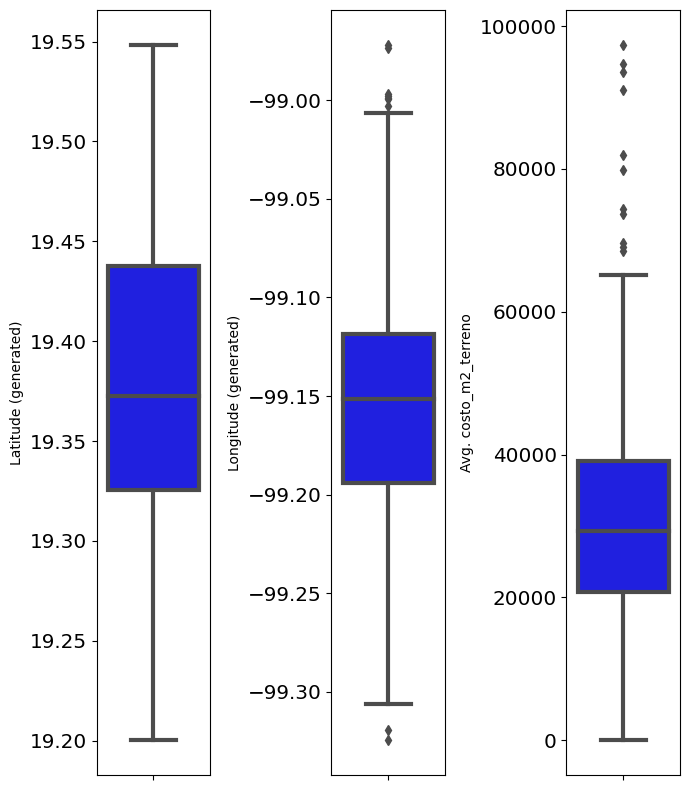

In [113]:
col_num=['Latitude (generated)','Longitude (generated)','Avg. costo_m2_terreno']
for i in range(0,len(col_num)):
    plt.subplot(1, len(col_num), i+1)
    sns.boxplot(y=X[col_num[i]], color='blue', orient='v')
    plt.tight_layout()


In [158]:
col_num=['Avg. costo_m2_terreno']
df_Limpieza = X
print(f'Tamaño muestra: {len(df_Limpieza)}')

filtro1 = np.array([True] * len(df_Limpieza))

for col in col_num:
    zscore = abs(stats.zscore(df_Limpieza[col])) 
    filtro1 = (zscore < 2.5) & filtro1  #PONEMOS UN FILTRO DE ZSCORE >= 2.5
    
df_SinOutliers = df_Limpieza[filtro1] 

print(f'Total Outliers: {len(df_Limpieza)-len(df_SinOutliers)}')
print(f'Muestra sin Outliers: {len(df_SinOutliers)}')

Tamaño muestra: 869
Total Outliers: 8
Muestra sin Outliers: 861


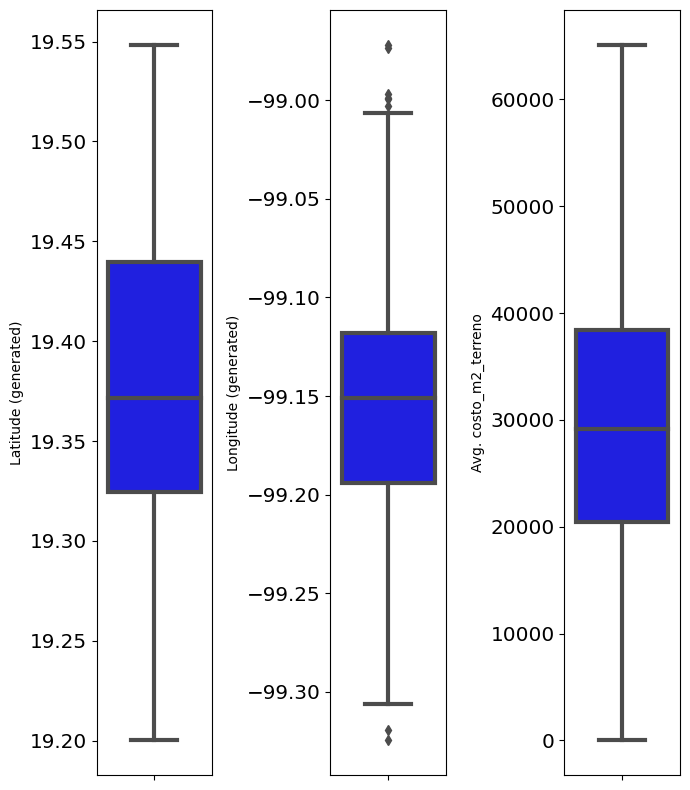

In [115]:
col_num=['Latitude (generated)','Longitude (generated)','Avg. costo_m2_terreno']
for i in range(0,len(col_num)):
    plt.subplot(1, len(col_num), i+1)
    sns.boxplot(y=df_SinOutliers[col_num[i]], color='blue', orient='v')
    plt.tight_layout()

Concatenamos con missing_cost

In [159]:
df_SinOutliers=pd.concat([df_SinOutliers,missing_cost])

Quitamos los acentos de la columna Alcaldía

In [162]:
def acentos(s):
    replacements=(('Á','A'),('É','E'),('Í','I'),('Ó','O'),('U','U'))
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

for i in df_SinOutliers['Alcaldía']:
    df_SinOutliers.loc[df_SinOutliers['Alcaldía']==i, 'Alcaldía']=acentos(i)


In [163]:
df_SinOutliers

,Colonia,Alcaldía,Latitude (generated),Longitude (generated),Avg. costo_m2_terreno
0,ZONA MILITAR FAVE SEDENA (U HAB),IZTAPALAPA,19.311541,-99.083730,0.000000
1,ZENON DELGADO,ALVARO OBREGON,19.389579,-99.216276,32988.000000
2,ZACAHUITZCO,IZTAPALAPA,19.374028,-99.135868,40967.555556
3,XOTEPINGO,COYOACAN,19.327916,-99.140440,39393.166667
4,XOCO,BENITO JUAREZ,19.361136,-99.167825,47916.315789
...,...,...,...,...,...
847,AGRICOLA ORIENTAL I,IZTACALCO,19.402220,-99.077949,0.000000
854,ACTIPAN,BENITO JUAREZ,19.369901,-99.178427,0.000000
859,20 DE NOVIEMBRE (AMPL),VENUSTIANO CARRANZA,19.443236,-99.114841,0.000000
864,10 DE ABRIL,MIGUEL HIDALGO,19.448867,-99.209112,0.000000


Distribución del precio por m2

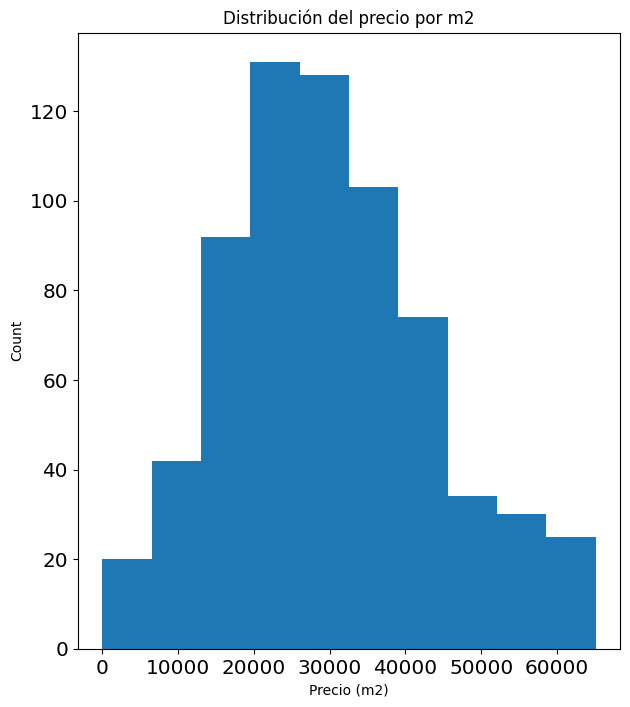

In [223]:
plt.hist(df_SinOutliers["Avg. costo_m2_terreno"])
plt.xlabel("Precio (m2)")
plt.ylabel("Count")
plt.title("Distribución del precio por m2");

Obtenemos el costo promedio por Alcaldía

In [199]:
df_promedio=df_SinOutliers.groupby('Alcaldía', as_index=False).mean()
df_promedio.sort_values(by=['Avg. costo_m2_terreno'])

C:\Users\Jhovany Lara\AppData\Local\Temp\ipykernel_13452\2826246246.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_promedio=df_SinOutliers.groupby('Alcaldía', as_index=False).mean()


,Alcaldía,Latitude (generated),Longitude (generated),Avg. costo_m2_terreno
11,TLAHUAC,19.284817,-99.026573,12600.134615
14,XOCHIMILCO,19.255259,-99.103739,17837.437500
8,IZTAPALAPA,19.355953,-99.077948,19977.132937
13,VENUSTIANO CARRANZA,19.426288,-99.102725,23002.401985
6,GUSTAVO A. MADERO,19.489887,-99.115537,23411.816621
7,IZTACALCO,19.397434,-99.096091,23478.637418
1,AZCAPOTZALCO,19.481230,-99.183705,26122.224015
12,TLALPAN,19.280202,-99.171182,28113.571701
9,LA MAGDALENA CONTRERAS,19.312008,-99.238989,28128.994962
3,COYOACAN,19.325575,-99.145030,32621.020642


Ploteamos un Mapbox donde vemos donde se concentran las zonas con el mayor costo

In [204]:
EDA=df_SinOutliers

fig = px.scatter_mapbox(
    EDA,
    lat = "Latitude (generated)",
    lon = "Longitude (generated)",
    #center = {"lat": 19.6345, "lon": -99.5528},
    color = "Avg. costo_m2_terreno",
    width = 900,
    height = 600,
    hover_data = ["Colonia", "Avg. costo_m2_terreno"]
);

fig.update_layout(mapbox_style="open-street-map")
fig.show()

## Análisis preliminar geojson

In [2]:
geo=gpd.read_file('CDMX_colonias.geojson')
geo.head()

,sta_name,col_area_code,col_code,col_type,mun_name,year,col_name,mun_code,sta_code,geometry
0,Ciudad de México,MEX,10-200,colonia,Álvaro Obregón,2019,Santa Lucia,09010,09,"POLYGON ((-99.25760 19.35510, -99.25719 19.354..."
1,Ciudad de México,MEX,15-012,colonia,Cuauhtémoc,2019,Ex Hipodromo De Peralvillo,09015,09,"POLYGON ((-99.14022 19.46039, -99.14006 19.460..."
2,Ciudad de México,MEX,12-204,colonia,Tlalpan,2019,Zapote-Luis Donaldo Colosio (U Habs),09012,09,"POLYGON ((-99.17772 19.29994, -99.17764 19.300..."
3,Ciudad de México,MEX,12-201,colonia,Tlalpan,2019,Xaxalipac,09012,09,"POLYGON ((-99.14485 19.18065, -99.14449 19.180..."
4,Ciudad de México,MEX,10-238,colonia,Álvaro Obregón,2019,Villa Verdun,09010,09,"POLYGON ((-99.25172 19.33917, -99.25226 19.339..."


In [9]:
from shapely.geometry import Point, Polygon
p1=Point(19.413464, -99.135515)
dentro=False
for i in geo['geometry']:
    if p1.within(i):
        dentro=True
    
dentro

False

In [6]:
geo['geometry']

0       POLYGON ((-99.25760 19.35510, -99.25719 19.354...
1       POLYGON ((-99.14022 19.46039, -99.14006 19.460...
2       POLYGON ((-99.17772 19.29994, -99.17764 19.300...
3       POLYGON ((-99.14485 19.18065, -99.14449 19.180...
4       POLYGON ((-99.25172 19.33917, -99.25226 19.339...
                              ...                        
1810    POLYGON ((-99.15948 19.30381, -99.15940 19.303...
1811    POLYGON ((-99.22484 19.26676, -99.22594 19.267...
1812    POLYGON ((-99.15186 19.46803, -99.15187 19.468...
1813    POLYGON ((-99.03084 19.36307, -99.03041 19.362...
1814    POLYGON ((-99.07382 19.28951, -99.07377 19.289...
Name: geometry, Length: 1815, dtype: geometry

<AxesSubplot: >

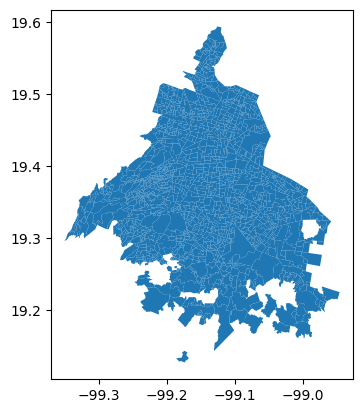

In [201]:
geo.plot()

In [210]:
geo2=geo.copy()

In [211]:
geo2['geometry']=geo2['geometry'].astype(str)
full=geo2.geometry.str.split(',', expand=True)

c:\Users\Jhovany Lara\AppData\Local\Programs\Python\Python38\lib\site-packages\geopandas\geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


Vemos si es posible llenar las alcaldías faltantes en df con los datos del geojson

In [180]:
#Cambiamos todo a mayusculas para que coincida con el df
geo['col_name']=geo['col_name'].str.upper()
geo['mun_name']=geo['mun_name'].str.upper()

In [144]:
#Creamos un diccionario
mun=geo.mun_name.values.tolist()
col=geo.col_name.values.tolist()
dicc=dict(zip(col, mun))


Nos damos cuenta que no es posible obtener la Alcaldía con el nombre de la colonia en geojson

In [ ]:
A=geo[geo.col_name.str.contains('BUENAVISTA')]
A

## Usando urbanpy para obtener datos

In [4]:
mx=up.download.nominatim_osm('Ciudad de Mexico, Mexico')

In [72]:
from shapely.geometry import Point, Polygon
p1=Point(19.417522, -99.139572)
Polygono=Polygon(mx['geometry'][0])
p1.within(Polygono)

False

In [76]:
Polygono.contains(p1)

False

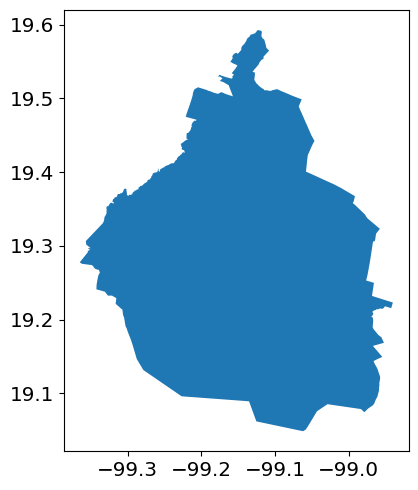

In [62]:
fig, (ax1) = plt.subplots(1, figsize=(12,5))

mx.plot(ax=ax1)

plt.tight_layout()
plt.show()

In [165]:
hex_mx=up.geom.gen_hexagons(8, mx)
hex_mx.shape

(1767, 2)

Text(0.5, 1.0, 'CDMX, Celdas H3 de resolución 8')

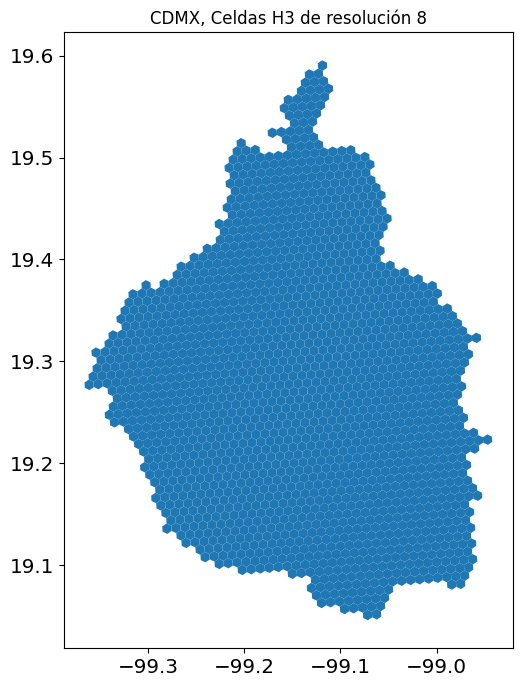

In [166]:
hex_mx.plot()
plt.title('CDMX, Celdas H3 de resolución 8')

In [ ]:
pop_df = up.download.hdx_fb_population('argentina', 'full') #Está caida la pagina (HTTP Error 404: Not Found)

Obtenemos los datos de salud

In [121]:
es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='health')

In [68]:
es.poi_type.value_counts()  #Vemos los datos que toma en cuenta

pharmacy    610
hospital    165
dentist      98
clinic       92
doctors      86
Name: poi_type, dtype: int64

Text(0.5, 1.0, 'CDMX Puntos de interes OSM, categoria salud')

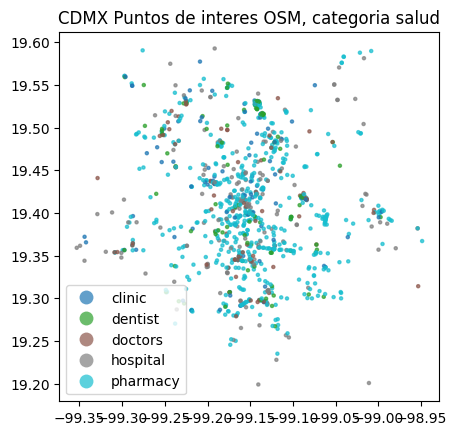

In [30]:
es.plot('poi_type', markersize=5, alpha = 0.7, legend=True)
plt.title('CDMX Puntos de interes OSM, categoria salud')

Extraemos solo los datos de hospitales

In [31]:
hospitales=es[es['poi_type']=='hospital']

<AxesSubplot: >

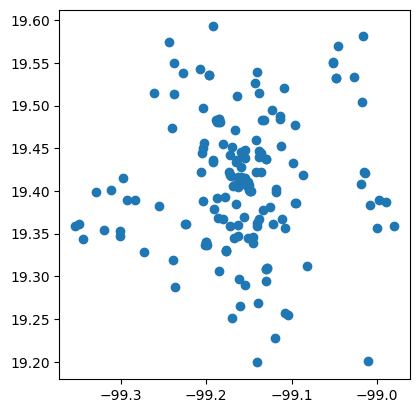

In [32]:
hospitales.plot()

Tomamos los centroides de cada hexágono

In [33]:
hex_mx['lat']=hex_mx.geometry.centroid.y
hex_mx['lon']=hex_mx.geometry.centroid.x

Distancia vuelo de pájaro

In [34]:
dist_up, ind_up=up.utils.nn_search(
    tree_features=hospitales[['lat','lon']].values,#Puntos de interes
    query_features=hex_mx[['lat','lon']].values,#Centroides de los hexagonos
    metric='haversine' #Metrica de distancia
)

In [39]:
hex_mx['hosp_cercano']=ind_up
hex_mx['distancia (km)']=dist_up
hex_mx.head()

,hex,geometry,lat,lon,hosp_cercano,distancia,distancia (km)
0,8849958017fffff,"POLYGON ((-99.04043 19.21087, -99.03591 19.213...",19.216012,-99.040782,48,3.550772,3.550772
1,8849959731fffff,"POLYGON ((-99.14552 19.09433, -99.14101 19.097...",19.099476,-99.145882,45,11.093977,11.093977
2,8849958095fffff,"POLYGON ((-99.07179 19.25502, -99.06727 19.257...",19.260168,-99.072142,47,3.491039,3.491039
3,8849958419fffff,"POLYGON ((-99.18772 19.29277, -99.18321 19.295...",19.297913,-99.188084,6,0.962638,0.962638
4,884995bb15fffff,"POLYGON ((-99.11592 19.41461, -99.11140 19.417...",19.419753,-99.116282,41,1.914156,1.914156


Ahora tomamos las coordenadas de la tabla df_SinOutliers

In [70]:
cdmx=df_SinOutliers
cdmx.rename(columns={'Latitude (generated)':'lat','Longitude (generated)':'lon'}, inplace=True) #renombramos las columnas de coordenadas
dist_up, ind_up=up.utils.nn_search(
    tree_features=hospitales[['lat','lon']].values,#Puntos de interes
    query_features=cdmx[['lat','lon']].values,#Centroides de los hexagonos
    metric='haversine' #Metrica de distancia
)

Cargamos la distancia y cantidad al dataset

In [71]:
cdmx['hosp_cercano']=ind_up
cdmx['distancia (km)']=dist_up
cdmx.head()

,Colonia,Alcaldía,lat,lon,Avg. costo_m2_terreno,hosp_cercano,distancia (km)
1,ZENON DELGADO,ALVARO OBREGON,19.389579,-99.216276,32988.000000,111,1.268749
2,ZACAHUITZCO,IZTAPALAPA,19.374028,-99.135868,40967.555556,139,0.446150
3,XOTEPINGO,COYOACAN,19.327916,-99.140440,39393.166667,161,1.393580
4,XOCO,BENITO JUAREZ,19.361136,-99.167825,47916.315789,29,0.575230
5,VISTA ALEGRE,CUAUHTEMOC,19.410148,-99.133091,22941.000000,113,1.340451


Cargamos datos de salud a tabla cdmx

In [167]:
cdmx=df_SinOutliers
cdmx.rename(columns={'Latitude (generated)':'lat','Longitude (generated)':'lon'}, inplace=True) #renombramos las columnas de coordenadas

In [169]:
es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='health')

In [170]:
health=['hospital', 'pharmacy','clinic', 'dentist', 'doctors']
for i in health:
    z=es[es['poi_type']==i]
    dist_up, ind_up=up.utils.nn_search(
        tree_features=z[['lat','lon']].values,#Puntos de interes
        query_features=cdmx[['lat','lon']].values,#coordenadas de cada colonia
        metric='haversine' #Metrica de distancia
    )
    cdmx[f'{i}_near']=ind_up
    cdmx[f'{i}_dist(km)']=dist_up


Obtenemos datos de alimentos

In [171]:
es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='food')

In [ ]:
es.poi_type.value_counts()  #Vemos los datos que toma en cuenta

Cargamos datos de alimentos

In [173]:
food=['convenience', 'supermarket','butcher', 'marketplace', 'greengrocer','mall']

for i in food:
    z=es[es['poi_type']==i]
    dist_up, ind_up=up.utils.nn_search(
        tree_features=z[['lat','lon']].values,#Puntos de interes
        query_features=cdmx[['lat','lon']].values,#coordenadas de cada colonia
        metric='haversine' #Metrica de distancia
    )
    cdmx[f'{i}_near']=ind_up
    cdmx[f'{i}_dist(km)']=dist_up

Obtenemos datos de educación

In [174]:
es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='education')
es.poi_type.value_counts()  #Vemos los datos que toma en cuenta

school             518
university          80
kindergarten        73
college             20
music_school         6
prep_school          4
language_school      1
dance_school         1
driving_school       1
Name: poi_type, dtype: int64

Cargamos datos de educación

In [175]:
education=['school', 'university','kindergarten']

for i in education:
    z=es[es['poi_type']==i]
    dist_up, ind_up=up.utils.nn_search(
        tree_features=z[['lat','lon']].values,#Puntos de interes
        query_features=cdmx[['lat','lon']].values,#coordenadas de cada colonia
        metric='haversine' #Metrica de distancia
    )
    cdmx[f'{i}_near']=ind_up
    cdmx[f'{i}_dist(km)']=dist_up

Obtenemos datos financieros

In [176]:
es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='finance')
es.poi_type.value_counts()  #Vemos los datos que toma en cuenta

bank                724
atm                 114
post_office          75
bureau_de_change     10
money_transfer        1
Name: poi_type, dtype: int64

In [177]:
finance=['bank', 'atm']

for i in finance:
    z=es[es['poi_type']==i]
    dist_up, ind_up=up.utils.nn_search(
        tree_features=z[['lat','lon']].values,#Puntos de interes
        query_features=cdmx[['lat','lon']].values,#coordenadas de cada colonia
        metric='haversine' #Metrica de distancia
    )
    cdmx[f'{i}_near']=ind_up
    cdmx[f'{i}_dist(km)']=dist_up

In [178]:
cdmx.tail()

,Colonia,Alcaldía,lat,lon,Avg. costo_m2_terreno,hospital_near,hospital_dist(km),pharmacy_near,pharmacy_dist(km),clinic_near,...,school_near,school_dist(km),university_near,university_dist(km),kindergarten_near,kindergarten_dist(km),bank_near,bank_dist(km),atm_near,atm_dist(km)
847,AGRICOLA ORIENTAL I,IZTACALCO,19.402220,-99.077949,0.0,120,2.077254,326,0.761217,35,...,249,1.270820,16,1.565890,4,1.532572,630,0.687251,91,2.167467
854,ACTIPAN,BENITO JUAREZ,19.369901,-99.178427,0.0,13,0.348693,435,0.402571,61,...,1,0.643761,1,1.044131,71,2.381655,493,0.272007,83,1.249524
859,20 DE NOVIEMBRE (AMPL),VENUSTIANO CARRANZA,19.443236,-99.114841,0.0,23,1.000014,554,0.288363,28,...,465,0.128329,6,4.637980,34,1.782714,622,0.489317,9,2.433791
864,10 DE ABRIL,MIGUEL HIDALGO,19.448867,-99.209112,0.0,44,0.642178,274,0.905279,2,...,200,0.543641,5,5.276639,55,2.638372,678,0.062848,14,0.917545
867,5 DE MAYO,MIGUEL HIDALGO,19.448798,-99.199958,0.0,44,0.407873,347,0.988985,2,...,93,0.890721,6,4.550125,55,2.349347,21,0.548493,82,0.966389


In [181]:
cdmx.to_csv('CDMX.csv', index=False)

In [ ]:
up.routing.start_osrm_server('argentina', 'south-america', 'foot') #No levanta el contenedor

In [26]:
def within_CDMX(lat,lon):
    coord=(lat, lon)
    geolocator=Nominatim(user_agent='test/1')
    location=geolocator.reverse(coord) #Aquí ya tenemos la dirección completa
    strloc=str(location) #cambiamos el tipo de dato a string
    dentro=False
    if 'Ciudad de México' in strloc:
        dentro=True
    if 'Ciudad de Mexico' in strloc:
        dentro=True
    return dentro

In [29]:
within_CDMX(19.20, -99.8)

False